In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sentence_transformers

In [ ]:
import numpy as np
import pandas as pd
import chardet
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import plot_model
import pickle
import torch
import math
import torch
from transformers import pipeline


# Load Dataset

In [ ]:
f = '/content/drive/MyDrive/Spring 2024/AI_EarthHack_Dataset.csv'
data = pd.read_csv(f, encoding = 'latin-1')
data

,id,problem,solution
0,1,The construction industry is indubitably one o...,"Herein, we propose an innovative approach to m..."
1,2,"I'm sure you, like me, are feeling the heat - ...","Imagine standing on a green hill, not a single..."
2,3,The massive shift in student learning towards ...,"Implement a """"Book Swap"""" program within educa..."
3,4,The fashion industry is one of the top contrib...,The proposed solution is a garment rental serv...
4,5,The majority of the materials used in producin...,An innovative concept would be a modular elect...
...,...,...,...
1295,1296,"The linear 'take, make, dispose' model of prod...","Addressing this problem, a two-pronged circula..."
1296,1297,The conundrum we face is the improper disposal...,The proposed solution is a cutting-edge recycl...
1297,1298,This solution will help the vegetation,Use old tea bags as compost for soil
1298,1299,Accumulation and improper disposal of single-u...,My proposed solution is to implement an innova...


In [ ]:
data['problem'][0]

'The construction industry is indubitably one of the significant contributors to global waste, contributing approximately 1.3 billion tons of waste annually, exerting significant pressure on our landfills and natural resources. Traditional construction methods entail single-use designs that require frequent demolitions, leading to resource depletion and wastage.   '

In [ ]:
problems, solutions = list(data['problem']), list(data['solution'])

# Generate Embeddings

In [ ]:
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')
corpus_embeddings = embedder.encode(problems, batch_size=64, show_progress_bar=True, convert_to_tensor=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
len(corpus_embeddings)

1300

# Cluster similar problems

The first part of our solution is a clustering algorithm that group problems into categories. Users looking for a specific topic can choose from the cluster list we generated

In [ ]:
clusters = util.community_detection(corpus_embeddings, min_community_size=1, threshold=0.6)

# print("Clustering done after {:.2f} sec".format(time.time() - start_time))

#Print for all clusters the top 3 and bottom 3 elements
for i, cluster in enumerate(clusters):
    print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
    for sentence_id in cluster[0:3]:
        print("\t", problems[sentence_id])
    print("\t", "...")
    for sentence_id in cluster[-3:]:
        print("\t", problems[sentence_id])


Cluster 1, #569 Elements 
	 The construction industry is indubitably one of the significant contributors to global waste, contributing approximately 1.3 billion tons of waste annually, exerting significant pressure on our landfills and natural resources. Traditional construction methods entail single-use designs that require frequent demolitions, leading to resource depletion and wastage.   
	 The fashion industry is one of the top contributors to global pollution. The mass production, distribution and disposal of clothing is not sustainable long-term, leading to the release of greenhouse gases from manufacturing, shipping and wasted clothing in landfills.   
	 One major global issue we face today is the surplus of plastic waste. Single-use plastics are commonly used for packaging in various sectors, like retail, food, and manufacturing. These plastics, often non-recyclable or ignored during waste management, clog up our oceans, harm wildlife, and end up in landfills, where they take 

### Future step:

One next step we plan to do (but cannot finish) is that as we get a list of clusters, we want to use Generative AI to generate the category for each problem group. For example, cluster 0 is about the construction industry, and cluster 3 is about plastic waste.

# Scores Generation using GenAI

Then, as the user decide a problem category to look into, we want to show the list of problems with the highest scores in terms of relevancy, potential, and efficiency. As we start with no score criteria, we leverage GenAI to generate the initial scores

In [ ]:
!pip install accelerate

In [ ]:
pipe = pipeline("text-generation", model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", torch_dtype=torch.bfloat16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [ ]:
d = {}
for i, problem in enumerate(problems):
    prompt =  f'''
        Please follow exactly the instructions:

        Read the problem statement below:

        {problem}

        Score the problem statement by its relevancy, potential and efficiency on the scale of 1 to 100
        in the EXACT format below:

        relevancy: (Score)
        potential: (Score)
        efficiency: (score)

    '''
    messages = [
        # {
        #     "role": "system",
        #     "content": "You are a friendly chatbot who always responds in the style of a pirate",
        # },
        {"role": "user", "content": prompt},
    ]
    prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
    print('Problem: ', problem)

    s = outputs[0]["generated_text"]
    s = s.split('<|assistant|>', 1)[1].lower()
    try:
        res = s.split('relevancy: ', 1)
        rel_score = res[1].split()[0]

        p_score = s.split('potential: ', 1)[1].split()[0]

        eff_score = s.split('efficiency: ', 1)[1].split()[0]

        print('relevancy: ', rel_score)
        print('potential: ', p_score)
        print('efficiency: ', eff_score)

        d[i] = [rel_score, p_score, eff_score]
    except:
        print('erroneous answer: ', s)

Problem:  The construction industry is indubitably one of the significant contributors to global waste, contributing approximately 1.3 billion tons of waste annually, exerting significant pressure on our landfills and natural resources. Traditional construction methods entail single-use designs that require frequent demolitions, leading to resource depletion and wastage.   
relevancy:  97
potential:  98
efficiency:  98
Problem:  I'm sure you, like me, are feeling the heat - literally! With World Health Organization declaring climate change as ""the greatest threat to global health in the 21st century"", we're in a race against time to move away from fossil fuels to more efficient, less polluting electrical power. But as we take bold leaps into a green future with electric cars and heating, we're confronted with a new puzzle - generating enough electrical power without using fossil fuels!  
relevancy:  100
potential:  95
efficiency:  95
Problem:  The massive shift in student learning to

KeyboardInterrupt: 

In [ ]:
# Store results
with open('problem_score.pickle', 'wb') as f:
    pickle.dump(d, f)

In [ ]:
len(d)

26

# Problem Score Generator

In the case that it might be costly to generate the scores for all problems in the data, we build a regression model that can use the current data to predict the scores for remaining problems

In [ ]:
# load scores
with open('/content/drive/MyDrive/Spring 2024/problem_score.pickle', 'rb') as f:
    problem_set = pickle.load(f)

In [ ]:
# Construct training data
relevancy_scores, potential_scores, efficiency_scores = [], [], []
problem_ids = []
for problem in problem_set.keys():
    try:
        rel_score = float(problem_set[problem][0]) / 100 if float(problem_set[problem][0]) > 1 else float(problem_set[problem][0])
        p_score = float(problem_set[problem][1]) / 100 if float(problem_set[problem][1]) > 1 else float(problem_set[problem][1])
        eff_score = float(problem_set[problem][2]) / 100 if float(problem_set[problem][2]) > 1 else float(problem_set[problem][2])

        relevancy_scores.append(rel_score)
        potential_scores.append(p_score)
        efficiency_scores.append(eff_score)
        problem_ids.append(problem)
    except:
        continue

In [ ]:
print('number of problems: ', len(problem_ids))
print('min-max relevancy score: ', min(relevancy_scores) * 100, '-', max(relevancy_scores)* 100)
print('min-max potential score: ', min(potential_scores) * 100, '-', max(potential_scores) * 100)
print('min-max efficiency score: ', min(efficiency_scores) * 100, '-', max(efficiency_scores) * 100)

number of problems:  22
min-max relevancy score:  10.0 - 100.0
min-max potential score:  5.0 - 100.0
min-max efficiency score:  8.0 - 100.0


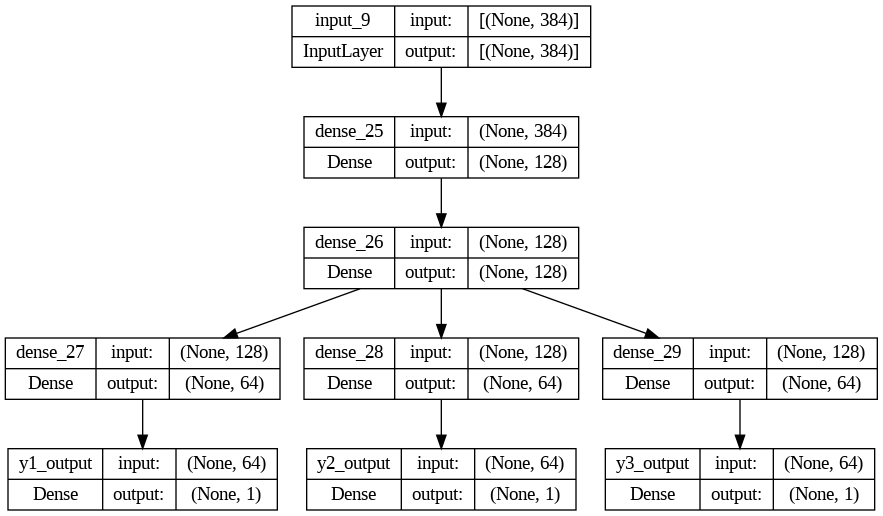

In [ ]:
# Build model
input_layer = Input(shape=(384))
dense_layer_1 = Dense(units = 128, activation = "relu")(input_layer)
dense_layer_2 = Dense(units = 128, activation = "relu")(dense_layer_1)

#Y1 output
dense_layer_3 = Dense(units = 64, activation = "relu")(dense_layer_2)
y1_output = Dense(units = 1, activation = "linear", name = "y1_output")(dense_layer_3)

#Y2 output
dense_layer_4 = Dense(units = 64, activation = "relu")(dense_layer_2)
y2_output = Dense(units = 1, activation = "linear", name = "y2_output")(dense_layer_4)

#Y3 output
dense_layer_5 = Dense(units = 64, activation = "relu")(dense_layer_2)
y3_output = Dense(units = 1, activation = "linear", name = "y3_output")(dense_layer_5)

#Define the model with the input layer and a list of outputs
model = Model(inputs = input_layer, outputs = [y1_output, y2_output, y3_output])

#specify the optimizer and compile with the loss function for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)

model.compile(optimizer = optimizer,
              loss = {'y1_output':'mse', 'y2_output':'mse', 'y3_output':'mse'},
              metrics = {
                  'y1_output':tf.keras.metrics.RootMeanSquaredError(),
                  'y2_output':tf.keras.metrics.RootMeanSquaredError(),
                  'y3_output':tf.keras.metrics.RootMeanSquaredError(),
              }
             )
plot_model(model, show_shapes = True)

In [ ]:
history = model.fit(np.array(torch.Tensor.cpu(corpus_embeddings[problem_ids])), (np.array(relevancy_scores), np.array(potential_scores), np.array(efficiency_scores)), epochs = 10, batch_size = 10)

Epoch 1/10
3/3 [==============================] - 1s 10ms/step - loss: 1.7320 - y1_output_loss: 0.4994 - y2_output_loss: 0.5347 - y3_output_loss: 0.6978 - y1_output_root_mean_squared_error: 0.7067 - y2_output_root_mean_squared_error: 0.7312 - y3_output_root_mean_squared_error: 0.8354
Epoch 2/10
3/3 [==============================] - 0s 10ms/step - loss: 0.9261 - y1_output_loss: 0.2663 - y2_output_loss: 0.3285 - y3_output_loss: 0.3313 - y1_output_root_mean_squared_error: 0.5161 - y2_output_root_mean_squared_error: 0.5731 - y3_output_root_mean_squared_error: 0.5756
Epoch 3/10
3/3 [==============================] - 0s 8ms/step - loss: 0.5231 - y1_output_loss: 0.1445 - y2_output_loss: 0.2135 - y3_output_loss: 0.1650 - y1_output_root_mean_squared_error: 0.3801 - y2_output_root_mean_squared_error: 0.4621 - y3_output_root_mean_squared_error: 0.4062
Epoch 4/10
3/3 [==============================] - 0s 9ms/step - loss: 0.3698 - y1_output_loss: 0.0977 - y2_output_loss: 0.1607 - y3_output_loss: 0

# Predict Score for other problems

Here, using our regression model, we can predict the scores for a different problem

In [ ]:
id = int(input('Input problem: '))
print('chosen problem: ', problems[id])

problem_embedding = np.array(torch.Tensor.cpu(corpus_embeddings[id]))
problem_embedding  = problem_embedding.reshape((1, 384))
preds = model.predict(problem_embedding)

print('predicted relevancy score: ', preds[0][0][0] * 100)
print('potential relevancy score: ', preds[1][0][0] * 100)
print('efficiency relevancy score: ', preds[2][0][0] * 100)

Input problem: 80
chosen problem:  The linear model of consumption and disposal in the tech industry significantly contributes to global e-waste problems and the unsustainable extraction of rare earth minerals. Businesses often cycle through tech devices at a rapid pace, resulting in increased environmental damage and financial costs.  
1/1 [==============================] - 0s 27ms/step
predicted relevancy score:  71.18973731994629
potential relevancy score:  62.85688281059265
efficiency relevancy score:  60.92464327812195


# Problem Score re-evaluation

The user can interact with our solution by modifying the current scores generated by GenAI and our regression model. Our system will then automatically retrain the model to provide better problem scores

In [ ]:
print('list of current problem ids in dataset: ', problem_ids)

list of current problem ids in dataset:  [0, 1, 2, 3, 7, 8, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 50]


In [ ]:
id = int(input('Input problem: '))
print('chosen problem: ', problems[id])

print('---- Current Scores -----')
problem_embedding = np.array(torch.Tensor.cpu(corpus_embeddings[id]))
problem_embedding  = problem_embedding.reshape((1, 384))
preds = model.predict(problem_embedding)

print('predicted relevancy score: ', preds[0][0][0] * 100)
print('predicted potential score: ', preds[1][0][0] * 100)
print('predicted efficiency score: ', preds[2][0][0] * 100)

print('----- New Proposed Scores ----')
new_rel = float(input('New relevancy score: '))
new_p = float(input('New potential score: '))
new_eff = float(input('New efficiency score: '))

if id not in problem_ids:
    print('add new problem to the training data...')
    relevancy_scores.append(new_rel / 100)
    potential_scores.append(new_p / 100)
    efficiency_scores.append(new_eff / 100)
    problem_ids.append(id)
else:
    print('modifying problem score in the training data...')
    curr_ind = problem_ids.index(id)
    relevancy_scores[curr_ind] = new_rel / 100
    efficiency_scores[curr_ind] = new_eff / 100
    potential_scores[curr_ind] = new_p / 100

Input problem: 90
chosen problem:  The overconsumption and wastage of materials in the hospitality industry lead to significant sustainability issues and increased costs.
---- Current Scores -----
1/1 [==============================] - 0s 82ms/step
predicted relevancy score:  91.5163516998291
potential potential score:  67.07707643508911
efficiency efficiency score:  97.95717000961304
----- New Proposed Scores ----
New relevancy score: 92
New potential score: 67
New efficiency score: 98
add new problem to the training data...


Re-train the regression model

In [ ]:
# Build model
input_layer = Input(shape=(384))
dense_layer_1 = Dense(units = 128, activation = "relu")(input_layer)
dense_layer_2 = Dense(units = 128, activation = "relu")(dense_layer_1)

#Y1 output
dense_layer_3 = Dense(units = 64, activation = "relu")(dense_layer_2)
y1_output = Dense(units = 1, activation = "linear", name = "y1_output")(dense_layer_3)

#Y2 output
dense_layer_4 = Dense(units = 64, activation = "relu")(dense_layer_2)
y2_output = Dense(units = 1, activation = "linear", name = "y2_output")(dense_layer_4)

#Y3 output
dense_layer_5 = Dense(units = 64, activation = "relu")(dense_layer_2)
y3_output = Dense(units = 1, activation = "linear", name = "y3_output")(dense_layer_5)

#Define the model with the input layer and a list of outputs
model = Model(inputs = input_layer, outputs = [y1_output, y2_output, y3_output])

#specify the optimizer and compile with the loss function for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)

model.compile(optimizer = optimizer,
              loss = {'y1_output':'mse', 'y2_output':'mse', 'y3_output':'mse'},
              metrics = {
                  'y1_output':tf.keras.metrics.RootMeanSquaredError(),
                  'y2_output':tf.keras.metrics.RootMeanSquaredError(),
                  'y3_output':tf.keras.metrics.RootMeanSquaredError(),
              }
             )

model = Model(inputs = input_layer, outputs = [y1_output, y2_output, y3_output])

#specify the optimizer and compile with the loss function for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)

model.compile(optimizer = optimizer,
              loss = {'y1_output':'mse', 'y2_output':'mse', 'y3_output':'mse'},
              metrics = {
                  'y1_output':tf.keras.metrics.RootMeanSquaredError(),
                  'y2_output':tf.keras.metrics.RootMeanSquaredError(),
                  'y3_output':tf.keras.metrics.RootMeanSquaredError(),
              }
)
history = model.fit(np.array(torch.Tensor.cpu(corpus_embeddings[problem_ids])), (np.array(relevancy_scores), np.array(potential_scores), np.array(efficiency_scores)), epochs = 10, batch_size = 10)

Epoch 1/10
3/3 [==============================] - 1s 11ms/step - loss: 1.6914 - y1_output_loss: 0.6539 - y2_output_loss: 0.6452 - y3_output_loss: 0.3923 - y1_output_root_mean_squared_error: 0.8087 - y2_output_root_mean_squared_error: 0.8032 - y3_output_root_mean_squared_error: 0.6263
Epoch 2/10
3/3 [==============================] - 0s 9ms/step - loss: 0.7464 - y1_output_loss: 0.2875 - y2_output_loss: 0.3190 - y3_output_loss: 0.1399 - y1_output_root_mean_squared_error: 0.5362 - y2_output_root_mean_squared_error: 0.5648 - y3_output_root_mean_squared_error: 0.3740
Epoch 3/10
3/3 [==============================] - 0s 9ms/step - loss: 0.4099 - y1_output_loss: 0.1377 - y2_output_loss: 0.1800 - y3_output_loss: 0.0922 - y1_output_root_mean_squared_error: 0.3711 - y2_output_root_mean_squared_error: 0.4243 - y3_output_root_mean_squared_error: 0.3036
Epoch 4/10
3/3 [==============================] - 0s 9ms/step - loss: 0.3102 - y1_output_loss: 0.0852 - y2_output_loss: 0.1422 - y3_output_loss: 0.

# Problem Similarity

As the user takes a look into some problems, our solution can also recommend similar problems to the user. We use a algorithm to compute the Cosine Similarity between the selected problem and other problems in the same category. Essentially, our work can recommend other problems/ideas that would be interesting to the user

In [ ]:
def find_cluster(problem_id):
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            if clusters[i][j] == problem_id:
                return i

In [ ]:
cluster_0 = clusters[0]
problem_id_in_cluster = 0
problem_id = cluster_0[problem_id_in_cluster]
print('problem: ', problems[problem_id])

cos = torch.nn.CosineSimilarity(dim=0)
min_cos_sim = - math.inf
most_similar = -1

for id in cluster_0:
    if id != problem_id:
        cos_sim = cos(corpus_embeddings[problem_id], corpus_embeddings[id])
        if cos_sim > min_cos_sim:
            min_cos_sim = cos_sim
            most_similar = id

print('most similar: ', problems[most_similar])
print('similarity score: ', min_cos_sim)

problem:  The construction industry is indubitably one of the significant contributors to global waste, contributing approximately 1.3 billion tons of waste annually, exerting significant pressure on our landfills and natural resources. Traditional construction methods entail single-use designs that require frequent demolitions, leading to resource depletion and wastage.   
most similar:  The construction industry is a major contributor to global waste and environmental degradation, primarily due to the prevalent ""build, use, dispose"" model. This linear approach leads to enormous amounts of waste, heavy reliance on natural resources, and substantial CO2 emissions. A comprehensive solution is needed to shift the paradigm towards more sustainable development and resource usage.  
similarity score:  tensor(0.8345)


In [ ]:
problem_id = int(input('Input problem id: '))
print('problem: ', problems[problem_id])

cluster_id = find_cluster(problem_id)
print('cluster: ', cluster_id)

top_k = int(input('Top similar problems (1-10): '))

cos = torch.nn.CosineSimilarity(dim=0)
problem_similarity = {}
for id in clusters[cluster_id]:
    if id != problem_id:
        cos_sim = cos(corpus_embeddings[problem_id], corpus_embeddings[id])
        problem_similarity[id] = cos_sim

top_similar_problems = sorted(problem_similarity.items(), key = lambda x : x[1], reverse = True)[:top_k]
print(f'----- Top {top_k} most similar problems ------')
for i, problem in enumerate(top_similar_problems):
    print('related problem ', i, ': ', problems[problem[0]])
    print('similarity score: ', problem[1], '\n')

Input problem id: 0
problem:  The construction industry is indubitably one of the significant contributors to global waste, contributing approximately 1.3 billion tons of waste annually, exerting significant pressure on our landfills and natural resources. Traditional construction methods entail single-use designs that require frequent demolitions, leading to resource depletion and wastage.   
cluster:  0
Top similar problems (1-10): 10
----- Top 10 most similar problems ------
related problem  0 :  The construction industry is a major contributor to global waste and environmental degradation, primarily due to the prevalent ""build, use, dispose"" model. This linear approach leads to enormous amounts of waste, heavy reliance on natural resources, and substantial CO2 emissions. A comprehensive solution is needed to shift the paradigm towards more sustainable development and resource usage.  
similarity score:  tensor(0.8345) 

related problem  1 :  Traditional methods of construction in